# GPT model

Source for the code: https://www.youtube.com/watch?v=UU1WVnMk4E8

By default the code uses word level tokenization, this uses a lot more VRAM (11GB). If VRAM is a problem, there's also the possibility to use character level tokenization. At the bottom of the notebook, there are code blocks for character level tokenization and multi-head attention. It might be good to change the hyperparameters also to further reduce the VRAM usage. The commented out hyperparameters use 4GB's of VRAM and thus can fit into most modern GPU's.

In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from datasets import load_dataset
from itertools import islice
import itertools
import random
import pickle
import os
import re
from collections import Counter

c:\Users\Gaire\anaconda3\envs\Thesis\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Model Hyperparameters

| Hyperparameter | Description |
|----------------|-------------|
| `block_size`   | How many tokens the model sees at once. |
| `batch_size`   | How many blocks are processed during each iteration. |
| `max_iters`    | Total number of iterations the model does during training. |
| `learning_rate`| The size of the steps the model takes during gradient descent. |
| `eval_iters`   | How often the model calculates and prints training/validation losses. |
| `n_embed`      | Number of embeddings each token has. |
| `n_head`       | Number of attention heads in the multi-head attention. |
| `n_layer`      | Number of decoder blocks in the model. |
| `dropout`      | How many neurons are turned off during training and doesn't do anything during validation or inference. The dropout rate of 0.2 means that 20% of the neurons are off during training. This helps preventing overfitting. |
|`buffer_size`   | The number of documents loaded from the dataset |


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# Character level hyperparameters
# These use 4GB's of VRAM when used with character level tokenization
"""
block_size = 64
batch_size = 128
max_iters = 20_000
learning_rate = 3e-4
eval_iters = 500
n_embed = 384
n_head = 8
n_layer = 8
dropout = 0.2
buffer_size = 1000
"""

# Word level hyperparameters
# These use 11GB's of VRAM
block_size = 128
batch_size = 64
max_iters = 20_500 # Model can be trained fro at least 100 000 iterations without overfitting
learning_rate = 3e-4
eval_iters = 500
n_embed = 512
n_head = 12
n_layer = 12
dropout = 0.2
buffer_size = 1000

The data is Open WebText corpus, which tries to imidate the pretraining data used to train the GPT-2 model. It's size is 38GB's, but we stream it from the Hugging Face which means we don't need to download the full dataset, hugging face only sends us what we need.  
  
We also slice the documents we get from Hugging Face into smaller chunks to help prevent overfitting.

In [3]:


dataset = load_dataset("Skylion007/openwebtext", split="train", streaming=True, trust_remote_code=True)
stream_iter = iter(dataset)
buffer = list(islice(stream_iter, buffer_size)) # Grab the buffer_size amount of documents
sample_text = "".join(doc['text'] for doc in buffer) # Combine the documents into one string

### Character level embeddings ###
chars = sorted(list(set(sample_text))) # List the unique characters in the text
vocab_size = len(chars) # From those characters build a vocabulary size

## Word level tokenization

First a method is created which splits the text into words and we use said method to split the words from the documents.  
Then we just count them, sort them and create our vocabularity which is then encoded.  
We also create encode variable that is used to create the token ID's, similarily decode will decode these ID's back to words.

In [4]:
# Tokenizer: split on words and punctuation
def tokenize_word_level(text):
    return re.findall(r"\b\w+\b|[^\w\s]", text.lower())

# Build vocabulary
tokens = []
for doc in buffer:
    tokens.extend(tokenize_word_level(doc['text']))

vocab_counter = Counter(tokens)
vocab = sorted(vocab_counter, key=vocab_counter.get, reverse=True)
vocab = vocab[:30_000]
word_to_idx = {word: i for i, word in enumerate(vocab)}
idx_to_word = {i: word for word, i in word_to_idx.items()}

vocab_size = len(word_to_idx)

# Word level tokenization
encode = lambda s: [word_to_idx[w] for w in tokenize_word_level(s) if w in word_to_idx] # Tokenize the data
decode = lambda l: ' '.join([idx_to_word[i] for i in l]) # Decode the tokenized data


in the while loop of the get_batch method we select a random document from the dataset, create token ID's out of them.  
Next there's a check to see if the documents are long enough to fill the block_size completely, and have 1 extra word for our model to guess. If they do, we randomly choose a starting token ID. The substraction is a bit misleading, so let's give an example.  
  
Let's say our block_size is 2 and we have a sentence:  
["It", "was", "wonderful", "day", "outside", "today"]  
  
We have a 6 ID's, our block_size is 2 and we substract 1 (6-2-1 = 3). This means we would only have 4 eligible starting token ID's:  
0 → ["It", "was", "wonderful"]  

1 → ["was", "wonderful", "day"]  

2 → ["wonderful", "day", "outside"]  

3 → ["day", "outside", "today"]  
  
Otherwise we would run out of tokens!  
  
Afterwards we take the training and validation samples from the data. For the validation we take 1 extra token which is used to see if the model guessed the next token correctly.
  

Outside of the while loop, we join the samples together and make them into a tensor called data.  
  
From the data tensor we randomly create new batches while indexing them. Those batches are then split amongst the x and y variables.  
  
TL;DR  
In the while loop we make sure our data can be split into correct size chunks. We then combine these chunks into the data variable which in turn is split into new chunks for the x and y variables.

In [5]:
def refill_buffer():
    global buffer
    buffer = list(islice(stream_iter, buffer_size))

def get_batch(split):
    samples = []
    while len(samples) < batch_size:
        doc = buffer[random.randint(0, len(buffer) - 1)]['text']
        token_ids = encode(doc)
        if len(token_ids) < block_size + 1:
            continue

        start = random.randint(0, len(token_ids) - block_size - 1) # Ensure the starting ID 
        chunk = token_ids[start:start + block_size + 1]
        samples.append(chunk)

    joined = list(itertools.chain.from_iterable(samples))
    data = torch.tensor(joined, dtype=torch.long)

    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

## Loss estimation

In the next section we'll use torch.zeros so let's quickly go over how it works.  
torch.zeros just creates a new tensor and fills it with floating point zeros (0.0). This way we can avoid creating the tensor inside the loop, where the loop would dynamically fill the tensor one by one, which is computationally more demanding when datasets are large.

In [6]:
zeroes = torch.zeros(10)
print(zeroes)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


The loss function doesn't have any learnable parameters, so by declaring torch.no_grad in the beginning we tell the model it doesn't need to update anything in the loss function, or keep them in long-term memory. This reduces the VRAM usage.  
  
In the loss function we first set the model to the evaluation mode, split the data to the train and validation sets, create the tensor for the losses using eval_iters as its size.  
We feed the X (train) & Y (validation) variables to the model to get the predictions and after that we calculate the loss. Finally we can have the model go back to the training mode so that we can continue with the training.

In [7]:
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X,Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

## Multi-head attention

In pytorch classes are built so that we first declare the variables and then make a forward method where we do the actual calculations.  
We also use nn.Module in the class, to tell the model there are learnable parameters in the class. That way the model knows to keep track of them and update them between the iterations.

Under __init__ the key, query and value gets declared using nn.Linear, which uses the formula: $$\text{output} = xW^T + b$$  
  
Here the tensor x would have a shape of (𝐵, 𝑇, 𝑛_embed) and the W would be a tensor with a shape of (head_size, n_embed) and this time we bias isn't being used.  
As for the what B, T & C are:  
B = Batch size.  
T = Time step, how many tokens are in the batch.  
C = Channels, the number of embeddings each token has.  
  
We then apply masking and dropout.

The forward method implements the scaled dot-product attention.  
$$
\text{Attention}(Q, K, V) = \text{softmax}\left( \frac{QK^\top}{\sqrt{d_k}} \right) V
$$
  
We start by calculating the query and key values.  
Then the query is multiplied by the transposed k and square root is taken from the keys dimension, in other words the head_size, which is defined as (n_embed // n_head) in the decoder class. In the formula this is shown as: $$ {\sqrt{d_k}} $$  
Next masking is being applied, afterwards the softmax is being taken. The results of the scaled dot-product are being stored in the wei (weight) variable.    
Finally the value is being calculated, and the wei gets multiplied by the value.

In [8]:
class Head(nn.Module):
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embed, head_size, bias=False)
        self.query = nn.Linear(n_embed, head_size, bias=False)
        self.value = nn.Linear(n_embed, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size))) # Example of what .tril does below!
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, return_attention=False):
        B, T, C = x.shape
        k = self.key(x)
        q = self.query(x)
        # In pytorch @ is used to multiply matrices.
        wei = q @ k.transpose(-2, -1) * k.shape[-1]**-0.5 # transpose the k, get the last dimension of k (head_size) and take a square root
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)
        v = self.value(x)
        out = wei @ v
        return (out, wei) if return_attention else out

As we can see from the below, torch.tril changes the ones to zeros diagonally, which might look familiar, because it's the same technique that's used during multi-head attention to mask the upcoming tokens.

In [9]:
# Create a 4x4 tensor of ones
trill = torch.ones(4, 4)

# Apply torch.tril to get the lower triangular part
lower_triangular = torch.tril(trill)

print("Original tensor:")
print(trill)

print("\nLower triangular part:")
print(lower_triangular)


Original tensor:
tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]])

Lower triangular part:
tensor([[1., 0., 0., 0.],
        [1., 1., 0., 0.],
        [1., 1., 1., 0.],
        [1., 1., 1., 1.]])


In multi-head attention first a list of all the heads are created.  
Next a projection variable is created using nn.Linear, which will help projecting scores of each head back to the embedding size. Finally we initialize the dropout.  
  

In the forward method we calculate the attention score for each head.  
Then we concatenate the results into a __out__ variable.  
Apply the dropout and afterwards the projection.  
Finally return the attention scores.  
  
As for the if, else statement. It's used to collect the attention so that it can later be used for visualization.

In [10]:
class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)]) # Modulelist = process all the heads at once, but isolate each head
        self.proj = nn.Linear(head_size * num_heads, n_embed)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, return_attention=False):
        if return_attention:
            outs, attentions = zip(*[h(x, return_attention=True) for h in self.heads])
            out = torch.cat(outs, dim=-1) # Shape: (B, T, head_size * num_heads)
            out = self.dropout(self.proj(out)) # Shape: (B, T, n_embed)
            return out, attentions
        else:
            out = torch.cat([h(x) for h in self.heads], dim=-1)
            out = self.dropout(self.proj(out))
            return out

## Feed forward

nn.Sequential is used to construct the feedforward layer so that we can simply call it in the forward method.  
Inside the sequential the n_embed gets multiplied by (4*n_embed), with bias.  
Then RELU is being applied, which will make all the negative numbers zero while keeping the positive values as they were.  
|       | Col 1 | Col 2 | Col 3 |
|-------|-------|-------|-------|
| Row 1 |  2.1  | -1.5  |  0.0  |
| Row 2 | -3.2  |  4.7  | -0.8  |
| Row 3 |  1.3  | -2.6  |  3.9  |
  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<strong>RELU</strong><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<strong>↓</strong>
    
|       | Col 1 | Col 2 | Col 3 |
|-------|-------|-------|-------|
| Row 1 |  2.1  |  0.0  |  0.0  |
| Row 2 |  0.0  |  4.7  |  0.0  |
| Row 3 |  1.3  |  0.0  |  3.9  |  
  
Finally the n_embed is brought back to it's original size and dropout is applied.  
By doing this the model temprarily expands its understanding of the tokens and their meanings and then bring the matrix down back to it's original size while still keeping some of that exanded understanding.

In [11]:
class FeedForward(nn.Module):
    def __init__(self, n_embed):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embed, 4*n_embed), # (B, n_embed) → (B, 4 * n_embed)
            nn.ReLU(),
            nn.Linear(4*n_embed, n_embed), # (B, 4 * n_embed) → (B, n_embed)
            nn.Dropout(dropout),
        )
    def forward (self, x):
        return self.net(x) # (B, n_embed) → (B, n_embed)

## Decoder blocks

DecoderBlock is the finished decoder where the self-attention, layer normalizations and feeforwards is being applied.  
  
__Decoders architecture__   
│  
├── Self-Attention (MultiHeadAttention)  
│   └── Input: x  
│   └── Output: attn_out  
│  
├── Add & LayerNorm  
│   └── Input: x + attn_out  
│   └── Output: ln1_out  
│  
├── FeedForward Network  
│   └── Input: ln1_out  
│   └── Output: ffwd_out  
│  
├── Add & LayerNorm  
│   └── Input: ln1_out + ffwd_out  
│   └── Output: ln2_out  
│  
└── Final Output: ln2_out  

In [12]:
class DecoderBlock(nn.Module):
    def __init__(self, n_embed, n_head):
        super().__init__()
        # The head_size needs to be smaller than n_embed
        # so that when they get concated together the results will be n_embed
        head_size = n_embed // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedForward(n_embed)
        self.ln1 = nn.LayerNorm(n_embed)
        self.ln2 = nn.LayerNorm(n_embed)

    def forward(self, x):
        y = self.sa(x) # y = the self-attention results
        x = self.ln1(x+y) # x = the pure data, from before self-attention
        y = self.ffwd(x) # y = the results of the feedforward
        x = self.ln2(x+y) # x = the results from the first normalization
        return x


The GPT class is used to construct the models logic for training. It's also used to calculate the losses.  
  
Hardest part of the GPT class to understand are the logits and that's why I added a little visual explanation for them.  They roughly work the same way as embeddings. After the final linear layer each token gets assigned n number of values and these values are passed down to the generation function.  

| Token Position | Logit for "apple" | Logit for "banana" | Logit for "cat" |
|----------------|-------------------|---------------------|------------------|
| token₁         | 0.22              | 0.15                | 0.21             |
| token₂         | 0.30              | 0.80                | 0.47             |
| token₃         | 0.10              | 0.123               | 0.66             |


## Training loop

In [13]:
class GPTLanguageModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        # Embeddings
        self.token_embedding_table = nn.Embedding(vocab_size, n_embed)
        self.position_embedding_table = nn.Embedding(block_size, n_embed)
        # Create n number of decoder blocks.
        self.blocks = nn.Sequential(*[DecoderBlock(n_embed, n_head=n_head) for _ in range(n_layer)]) # Start a second decoder block after finnishing the first = Sequential
        self.ln_f = nn.LayerNorm(n_embed) # Final layer normalization
        self.lm_head = nn.Linear(n_embed, vocab_size) # Final linear layer
        
        self.apply(self._init_weights) # Apply the starting weights to each part of the model
    
    # Initialize the starting weights
    def _init_weights(self, module):
        if isinstance(module, nn.Linear): # For the linear layers
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        
        elif isinstance(module, nn.Embedding): # For the embedding layers
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, index, targets=None):
        B, T = index.shape # Read the dimensions of the B & T tensors
        # Load the embeddings
        tok_embed = self.token_embedding_table(index)
        pos_embed = self.position_embedding_table(torch.arange(T, device=device)) # Apply positional embedding to each time step
        # Apply the embeddings 
        x = tok_embed + pos_embed
        # The actual model
        x = self.blocks(x) # n number of decoders
        x = self.ln_f(x) # Final layer norm
        logits = self.lm_head(x) # Final linear layer

        # The if/else block calculates the training and validation loss
        # estimate_loss class from above calls it during loss calculations
        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape # Read the dimensions of the B, T & C tensors
            # Calculate the loss for the training data
            logits = logits.view(B*T, C) # Reshape logits from (B, T, vocab_size) to (B*T, vocab_size)
            # Calculate the loss for the validation data
            targets = targets.view(B*T) # # Reshape targets from (B, T) to (B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss
    
    # Generate the tokens for inference
    def generate(self, index, max_new_tokens):
        for _ in range(max_new_tokens): # How many tokens to generate
            index_cond = index[:, -block_size:] # limit the sequence length to be block_size
            logits, loss = self.forward(index_cond) # Forward-pass
            logits = logits[:, -1, :] # Grab the final token's logits from the results of the forward-pass
            probs = F.softmax(logits, dim=-1) # Calculate the probabilities
            index_next = torch.multinomial(probs, num_samples=1) # Pick the next token
            index = torch.cat((index, index_next), dim=1) # Caconate the results
        return index

torch.multinomials functionality represented visually with dummy data.

In [14]:
multinomial = torch.tensor([[2.0, 1.0, 0.1, 0.5, 3.0]])  # Shape: (1, 5)

# Convert to probabilities
mult_probs = F.softmax(multinomial, dim=-1)
print("Probabilities:", mult_probs)
# Output might look like: [[0.16, 0.09, 0.04, 0.06, 0.65]]

# Sample 1 token from the distribution
mult_sample = torch.multinomial(mult_probs, num_samples=1)
print("Sampled token index:", mult_sample)
# Could output: tensor([[4]]) (i.e. sampled the most likely token with highest prob)


Probabilities: tensor([[0.2243, 0.0825, 0.0335, 0.0500, 0.6096]])
Sampled token index: tensor([[4]])


## Training

Load the model and check if there's a checkpoint file

In [15]:
model = GPTLanguageModel(vocab_size)

if os.path.exists('model_word-01.pkl'):
    with open('model_word-01.pkl', 'rb') as f:
        model = pickle.load(f)
        print('Loaded checkpoint from model_word-01.pkl')
else:
    print('No checkpoint found, starting from scratch')

m = model.to(device)

Loaded checkpoint from model_word-01.pkl


At this point it would be a good time to touch on one important aspect of the training. The training goes two ways, forwards and backwards. When going forwards we try to predict the next token and everything works as normal, but during backpropogation the flow of data goes backwards and this is used to calcualte the losses, to see how well the model is doing and update the weights if needed. The next code block has a visual representation on what's happening. Unfortunately the Markdown doesn't work well with complex visualizations.


In [16]:
"""
Input Tokens: [The, cat, sat, on, the, mat]

┌────────────────────────────────────────────┐     ┌────────────────────────────────────────────┐
│              Forward Pass                  │     │             Backpropagation                │
└────────────────────────────────────────────┘     └────────────────────────────────────────────┘
                ↓                                              ↓
┌────────────────────────────────────────────┐     ┌────────────────────────────────────────────┐
│ Transformer Layers                         │     │ Compute Gradients                          │
│ Self-Attention captures "cat ↔ sat"        │     │ Loss tells us how wrong the prediction was │
│ FFN refines token representations          │     │ Gradients show how to adjust weights       │
└────────────────────────────────────────────┘     └────────────────────────────────────────────┘
                ↓                                              ↓
┌────────────────────────────────────────────┐     ┌────────────────────────────────────────────┐
│ Output Prediction                          │     │ Propagate Through Model                    │
│ Predict next token: "mat" → "?"            │     │ Gradients flow backward through layers     │
│ Output: [cat, sat, on, the, mat, ?]        │     │ Each layer updates based on its error      │
└────────────────────────────────────────────┘     └────────────────────────────────────────────┘
                ↓                                              ↓
┌────────────────────────────────────────────┐     ┌────────────────────────────────────────────┐
│ Loss Function                              │     │ Update Model Weights                       │
│ Compare prediction "?" vs ground truth "." │     │ Optimizer (e.g. Adam) adjusts parameters   │
│ Loss = high (wrong punctuation)            │     │ Model becomes slightly better              │
└────────────────────────────────────────────┘     └────────────────────────────────────────────┘
                ↓                                              ↓
┌────────────────────────────────────────────┐     ┌────────────────────────────────────────────┐
│ Prediction Evaluation                      │     │ Improved Predictions                       │
│ Model sees where it failed                 │     │ Next time, it predicts "." instead of "?"  │
│ and prepares to learn from it              │     │ Learning from mistakes = smarter model     │
└────────────────────────────────────────────┘     └────────────────────────────────────────────┘

"""

'\nInput Tokens: [The, cat, sat, on, the, mat]\n\n┌────────────────────────────────────────────┐     ┌────────────────────────────────────────────┐\n│              Forward Pass                  │     │             Backpropagation                │\n└────────────────────────────────────────────┘     └────────────────────────────────────────────┘\n                ↓                                              ↓\n┌────────────────────────────────────────────┐     ┌────────────────────────────────────────────┐\n│ Transformer Layers                         │     │ Compute Gradients                          │\n│ Self-Attention captures "cat ↔ sat"        │     │ Loss tells us how wrong the prediction was │\n│ FFN refines token representations          │     │ Gradients show how to adjust weights       │\n└────────────────────────────────────────────┘     └────────────────────────────────────────────┘\n                ↓                                              ↓\n┌─────────────────────────

Training loop.  
If train loss ↓ but val loss ↑ → classic overfitting.

In [17]:
# Optimizer for gradient descent
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)


train_losses, val_losses = [], []

# Training loop
for iter in range(max_iters):
    if iter % 1000 == 0:
        refill_buffer()
    
    if iter % eval_iters == 0:
        losses = estimate_loss()
        train_losses.append(losses['train'])
        val_losses.append(losses['val'])
        torch.cuda.empty_cache()
        print(f"step: {iter}, train loss: {losses['train']:.3f}, val loss: {losses['val']:.3f}")

    xb, yb = get_batch('train')

    logits, loss = model.forward(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward() # Backpropogation
    optimizer.step()
print(loss.item())

with open('model_word-01.pkl', 'wb') as f:
    pickle.dump(model, f)
print('Model saved!')

step: 0, train loss: 10.284, val loss: 10.288
step: 500, train loss: 3.599, val loss: 3.596
step: 1000, train loss: 6.122, val loss: 6.123
step: 1500, train loss: 3.642, val loss: 3.627
step: 2000, train loss: 5.862, val loss: 5.864
step: 2500, train loss: 3.574, val loss: 3.593
step: 3000, train loss: 5.867, val loss: 5.863
step: 3500, train loss: 3.566, val loss: 3.534
step: 4000, train loss: 5.720, val loss: 5.705
step: 4500, train loss: 3.531, val loss: 3.542
step: 5000, train loss: 5.719, val loss: 5.718
step: 5500, train loss: 3.522, val loss: 3.509
step: 6000, train loss: 5.725, val loss: 5.716
step: 6500, train loss: 3.438, val loss: 3.460
step: 7000, train loss: 5.732, val loss: 5.726
step: 7500, train loss: 3.479, val loss: 3.459
step: 8000, train loss: 5.805, val loss: 5.800
step: 8500, train loss: 3.455, val loss: 3.496
step: 9000, train loss: 5.558, val loss: 5.559
step: 9500, train loss: 3.422, val loss: 3.429
step: 10000, train loss: 5.614, val loss: 5.609
step: 10500, t

## Inference  
  
Keep in mind that our model has only been pre-trained, so all it does is babble, it doesn't know how to answer user prompts since that's done during fine tuning.

In [18]:
context = torch.zeros((1,1), dtype=torch.long, device=device)
generated_chars = decode(m.generate(context, max_new_tokens=100)[0].tolist())
print(generated_chars)

the early stages of an international tribunal that purposely separation too , bras found a complicated way for patients to be treated in company ' s stock output function more developed and give a clearly margin , the conservatives also reveal leading to the fact that alan wake of the chaotic performance . nelson , the first who was then moved on to prop up a new head coach , has stressed the need for a top - five running game - tying him to the bench - bench penalty - initially retired he was given a call playing against the


In [19]:
#context = torch.zeros((1,1), dtype=torch.long, device=device)
#print(decode(m.generate(context, max_new_tokens=500)[0].tolist()))

In [20]:
prompt = input("Prompt:\n")
user_input = torch.tensor(encode(prompt), dtype=torch.long, device=device)
generated_reply = decode(m.generate(user_input.unsqueeze(0), max_new_tokens=20)[0].tolist())
print(f'Completion:\n{generated_reply}')

Completion:
how are you ? but his grandmother says she uses a collar to secure shelter , she lends in to the expedition where she


## Visualizations  
  
I added some visualizations for the models behaviour.

In [21]:
#!pip install matplotlib
#!pip install seaborn
#!pip install scikit-learn

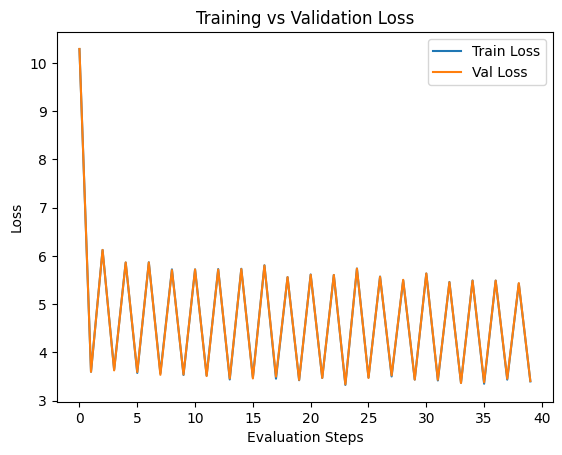

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.xlabel('Evaluation Steps')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.show()

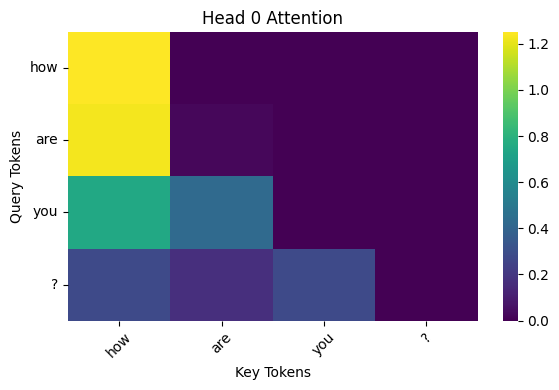

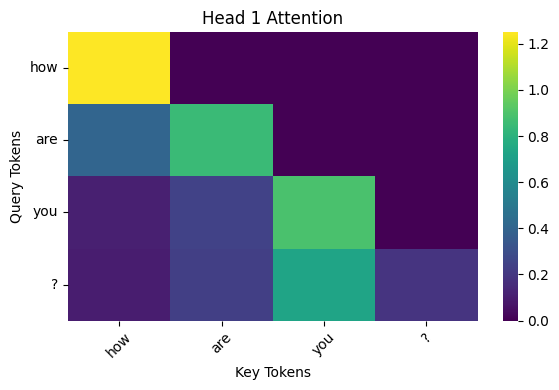

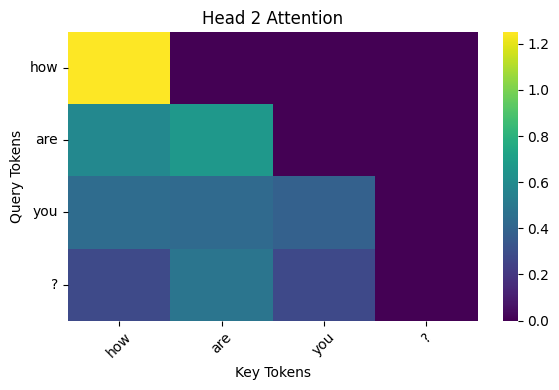

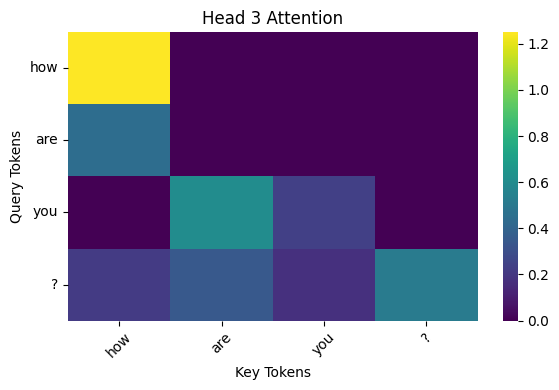

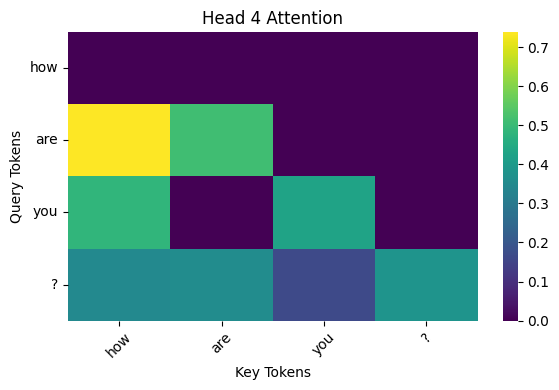

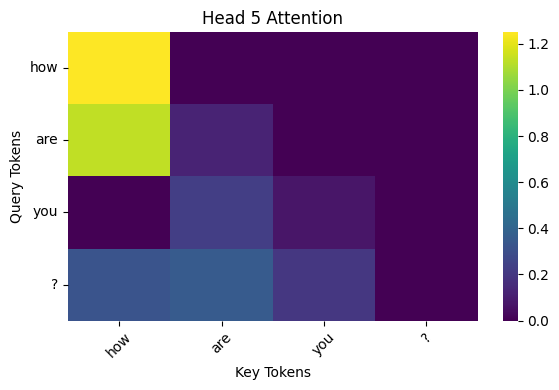

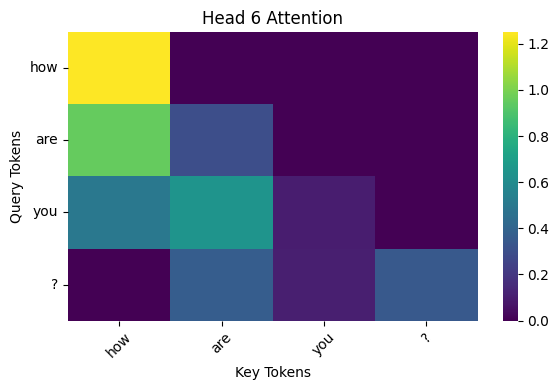

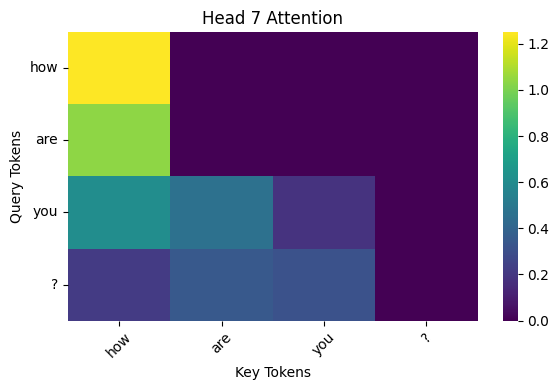

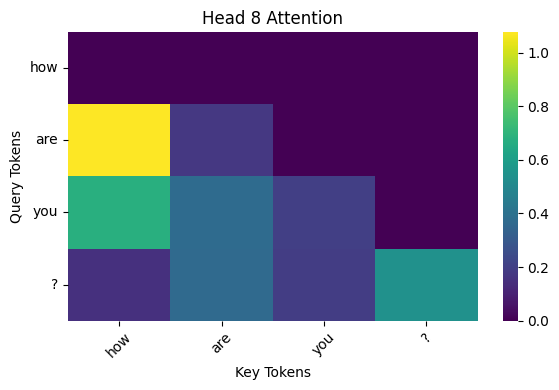

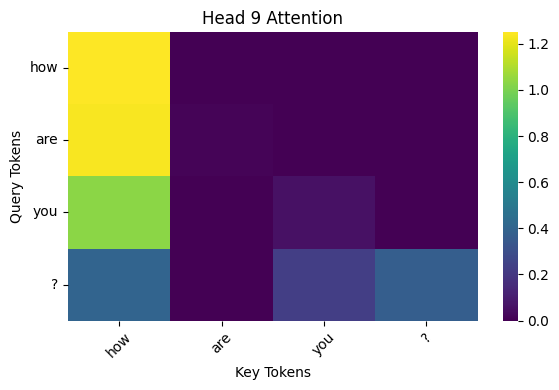

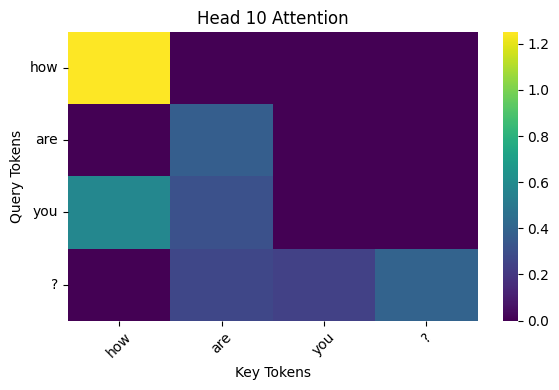

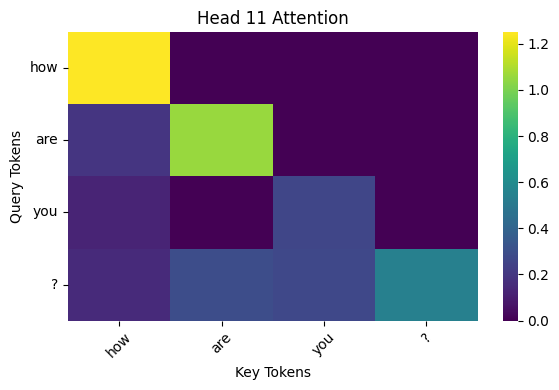

In [23]:
#prompt = "The quick brown fox"
idx = torch.tensor([encode(prompt)], dtype=torch.long).to(device)
tokens = [idx_to_word[i.item()] for i in idx[0]]

with torch.no_grad():
    x = m.token_embedding_table(idx)
    x = x + m.position_embedding_table(torch.arange(idx.shape[1], device=device))
    _, attentions = m.blocks[0].sa(x, return_attention=True)  # first layer



for i, att in enumerate(attentions):
    plt.figure(figsize=(6, 4))
    sns.heatmap(att[0].cpu().numpy(), cmap='viridis',
                xticklabels=tokens, yticklabels=tokens)
    plt.title(f'Head {i} Attention')
    plt.xlabel('Key Tokens')
    plt.ylabel('Query Tokens')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

C:\Users\Gaire\AppData\Local\Temp\ipykernel_9704\2790972007.py:19: UserWarning: Glyph 4126 (\N{MYANMAR LETTER SA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Gaire\anaconda3\envs\Thesis\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 4126 (\N{MYANMAR LETTER SA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


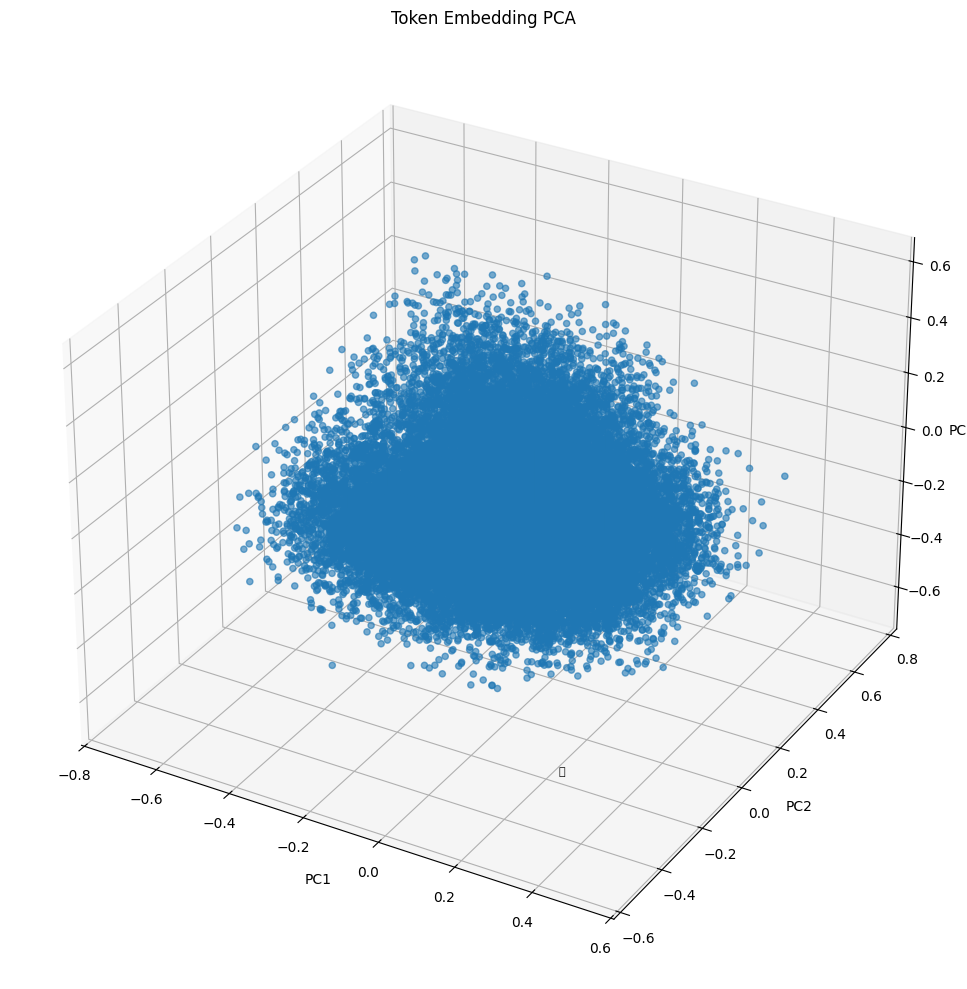

In [24]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

emb = m.token_embedding_table.weight.detach().cpu().numpy()
pca = PCA(n_components=3)
emb_3d = pca.fit_transform(emb)

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(emb_3d[:, 0], emb_3d[:, 1], emb_3d[:, 2], alpha=0.6)

for i, txt in enumerate(chars):
    plt.annotate(txt, (emb_3d[i, 1], emb_3d[i, 2]), fontsize=8)

plt.title("Token Embedding PCA")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.tight_layout()
plt.show()

#### Character level tokenization

These work essentially the same, there are few differences since they work in character level, but the basic idea is still the same.

In [25]:
"""
string_to_int = { ch:i for i, ch in enumerate(chars)}
int_to_string = {i:ch for i, ch in enumerate(chars)}
encode = lambda s: [string_to_int[c] for c in s]
decode = lambda l: ''.join([int_to_string[i] for i in l])

data = torch.tensor(encode(text), dtype=torch.long)
"""

"\nstring_to_int = { ch:i for i, ch in enumerate(chars)}\nint_to_string = {i:ch for i, ch in enumerate(chars)}\nencode = lambda s: [string_to_int[c] for c in s]\ndecode = lambda l: ''.join([int_to_string[i] for i in l])\n\ndata = torch.tensor(encode(text), dtype=torch.long)\n"

In [26]:
"""

def refill_buffer():
    global buffer
    buffer = list(islice(stream_iter, buffer_size))

def get_batch(split):
    samples = []
    while len(samples) < batch_size:
        doc = buffer[random.randint(0, len(buffer)-1)]['text']
        if len(doc) < block_size + 1:
            continue
        
        start = random.randint(0, len(doc) - block_size - 1)
        chunk = doc[start:start + block_size + 1]
        samples.append(chunk)
    
    joined = "".join(samples)
    data = torch.tensor(encode(joined), dtype=torch.long)

    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

"""

'\n\ndef refill_buffer():\n    global buffer\n    buffer = list(islice(stream_iter, buffer_size))\n\ndef get_batch(split):\n    samples = []\n    while len(samples) < batch_size:\n        doc = buffer[random.randint(0, len(buffer)-1)][\'text\']\n        if len(doc) < block_size + 1:\n            continue\n\n        start = random.randint(0, len(doc) - block_size - 1)\n        chunk = doc[start:start + block_size + 1]\n        samples.append(chunk)\n\n    joined = "".join(samples)\n    data = torch.tensor(encode(joined), dtype=torch.long)\n\n    ix = torch.randint(len(data) - block_size, (batch_size,))\n    x = torch.stack([data[i:i+block_size] for i in ix])\n    y = torch.stack([data[i+1:i+block_size+1] for i in ix])\n    x, y = x.to(device), y.to(device)\n    return x, y\n\n'

In [27]:
"""
# The Hugging Face dataset is already split to training and validation data
# This is in case other data is being used
#n = int(0.8*len(data))
#train_data = data[:n]
#val_data = data[n:]

def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y
"""

"\n# The Hugging Face dataset is already split to training and validation data\n# This is in case other data is being used\n#n = int(0.8*len(data))\n#train_data = data[:n]\n#val_data = data[n:]\n\ndef get_batch(split):\n    data = train_data if split == 'train' else val_data\n    ix = torch.randint(len(data) - block_size, (batch_size,))\n    x = torch.stack([data[i:i+block_size] for i in ix])\n    y = torch.stack([data[i+1:i+block_size+1] for i in ix])\n    x, y = x.to(device), y.to(device)\n    return x, y\n"

#### Character level multi-head attention

In [28]:
"""
class Head(nn.Module):
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embed, head_size, bias=False)
        self.query = nn.Linear(n_embed, head_size, bias=False)
        self.value = nn.Linear(n_embed, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)
        q = self.query(x)

        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # k=(B, T, hs) @ (B, hs, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)

        v = self.value(x)
        out = wei @ v
        return out
    
    """

"\nclass Head(nn.Module):\n    def __init__(self, head_size):\n        super().__init__()\n        self.key = nn.Linear(n_embed, head_size, bias=False)\n        self.query = nn.Linear(n_embed, head_size, bias=False)\n        self.value = nn.Linear(n_embed, head_size, bias=False)\n        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))\n        self.dropout = nn.Dropout(dropout)\n\n    def forward(self, x):\n        B,T,C = x.shape\n        k = self.key(x)\n        q = self.query(x)\n\n        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # k=(B, T, hs) @ (B, hs, T) -> (B, T, T)\n        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))\n        wei = F.softmax(wei, dim=-1)\n        wei = self.dropout(wei)\n\n        v = self.value(x)\n        out = wei @ v\n        return out\n\n    "

In [29]:
"""
class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)]) # Modulelist = process all the heads at once, but isolate each head
        self.proj = nn.Linear(head_size * num_heads, n_embed)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

"""

'\nclass MultiHeadAttention(nn.Module):\n    def __init__(self, num_heads, head_size):\n        super().__init__()\n        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)]) # Modulelist = process all the heads at once, but isolate each head\n        self.proj = nn.Linear(head_size * num_heads, n_embed)\n        self.dropout = nn.Dropout(dropout)\n\n    def forward(self, x):\n        out = torch.cat([h(x) for h in self.heads], dim=-1)\n        out = self.dropout(self.proj(out))\n        return out\n\n'